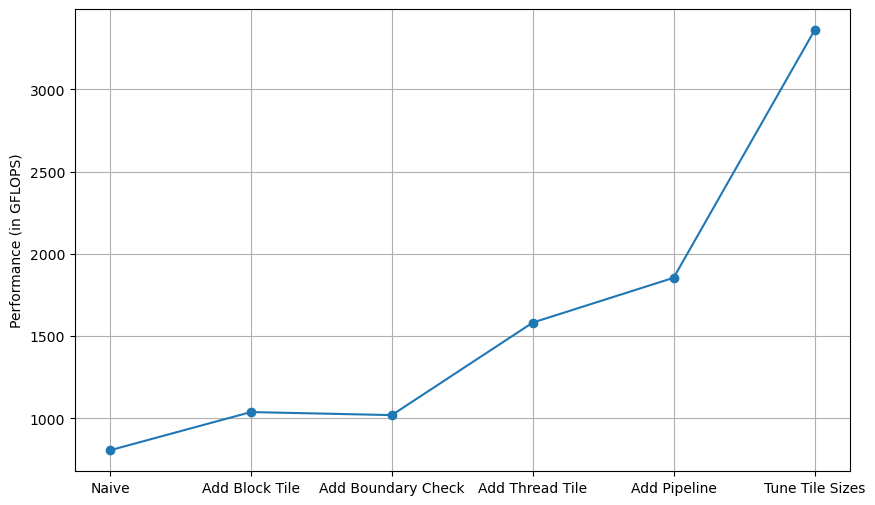

In [4]:
import matplotlib.pyplot as plt

# Data for the performance improvements
methods = [
    "Naive", "Add Block Tile", "Add Boundary Check",
    "Add Thread Tile", "Add Pipeline", "Tune Tile Sizes"
]
performance = [
    806.417467, 1038.736897, 1020.275850,
    1582.625983, 1855.127233, 3359.64
]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(methods, performance, marker='o', linestyle='-')
plt.ylabel("Performance (in GFLOPS)")
plt.grid(True)
plt.savefig("img/develop_process")
plt.show()


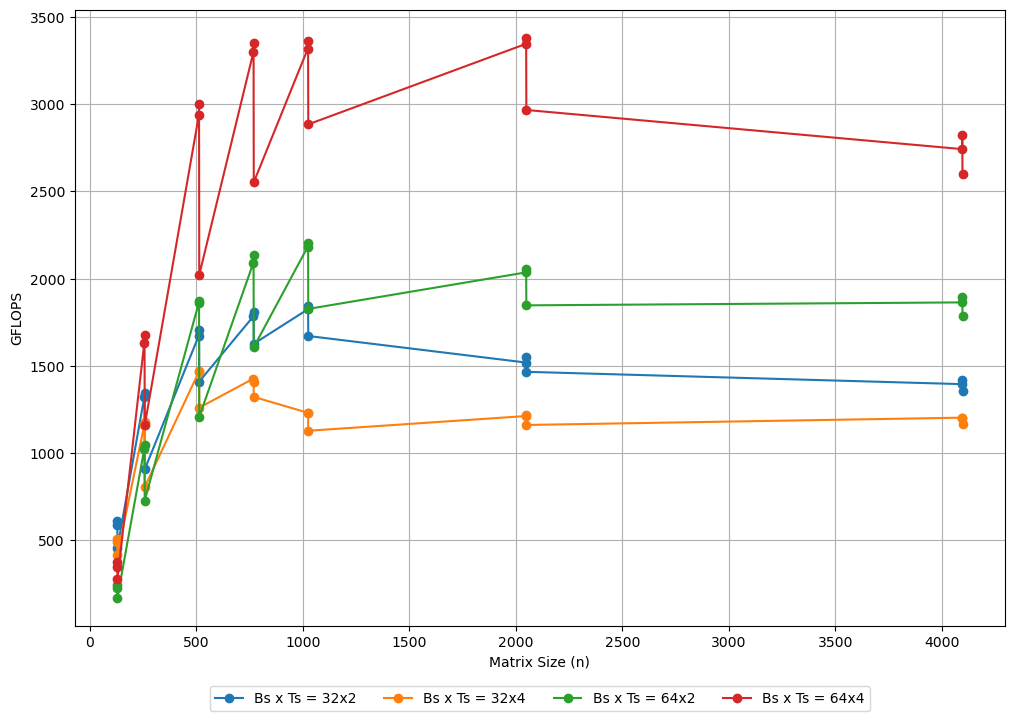

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '../results.csv'  # Update with your actual file path
data = pd.read_csv(file_path)
data['gflops'] = pd.to_numeric(data['gflops'], errors='coerce')
data['Bs_Ts'] = data['Bs'].astype(str) + 'x' + data['Ts'].astype(str)
filtered_data = data[(data['Bs_Ts'] == '32x2') | (data['Bs_Ts'] == '32x4') | (data['Bs_Ts'] == '64x2') | (data['Bs_Ts'] == '64x4')]

# Plotting
plt.figure(figsize=(12, 8))
for combo in ['32x2', '32x4', '64x2', '64x4']:
    subset = filtered_data[filtered_data['Bs_Ts'] == combo]
    plt.plot(subset['n'], subset['gflops'], marker='o', label=f'Bs x Ts = {combo}')

# Adding labels, title, and legend
plt.xlabel('Matrix Size (n)')
plt.ylabel('GFLOPS')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True)
plt.savefig("img/result")
plt.show()


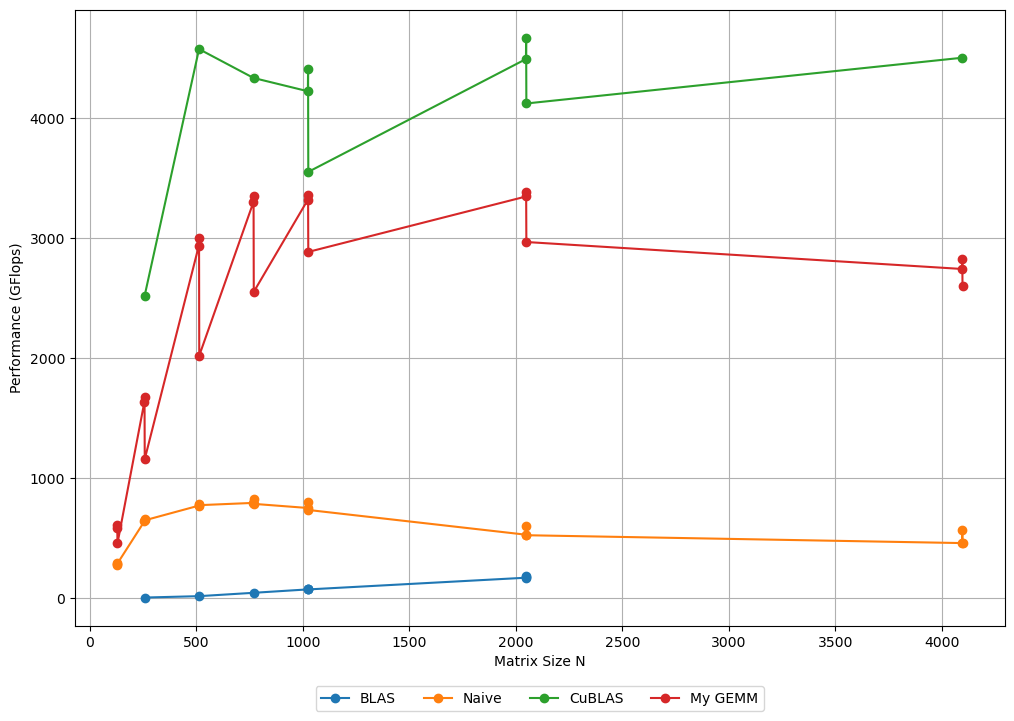

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation
data = {
    "N": [127, 128, 129, 255, 256, 257, 511, 512, 513, 767, 768, 769, 1023, 1024, 1025, 2047, 2048, 2049, 4095, 4096, 4097],
    "BLAS": [None, None, None, None, 5.84, None, None, 17.4, None, None, 45.3, None, 73.7, 73.6, 73.5, 171, 182, 175, None, None, None],
    "Naive": [280.77, 286.99, 289.98, 639.22, 657.96, 649.01, 771.30, 788.17, 775.21, 794.12, 830.18, 786.03, 751.69, 804.15, 735.28, 529.25, 605.77, 524.86, 459.44, 571.76, 458.25],
    "CuBLAS": [None, None, None, None, 2515.3, None, None, 4573.6, None, None, 4333.1, None, 4222.5, 4404.9, 3551.0, 4490.5, 4669.8, 4120.7, None, 4501.6, None],
    "My GEMM": [584.46, 608.73, 457.05, 1632.57, 1677.44, 1158.61, 2935.53, 3002.40, 2020.90, 3297.12, 3352.96, 2552.03, 3319.11, 3359.64, 2884.39, 3345.96, 3382.27, 2966.85, 2742.34, 2822.26, 2601.67]
}

df = pd.DataFrame(data)
df.set_index('N', inplace=True)

# Data Visualization
plt.figure(figsize=(12, 8))
for column in df.columns:
    # Temporary DataFrame to drop None values for plotting
    temp_df = df[column].dropna()
    plt.plot(temp_df.index, temp_df, marker='o', label=column)

# plt.title('Performance Comparison of GEMM Implementations')
plt.xlabel('Matrix Size N')
plt.ylabel('Performance (GFlops)')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True)
plt.savefig("img/comparison")
plt.show()


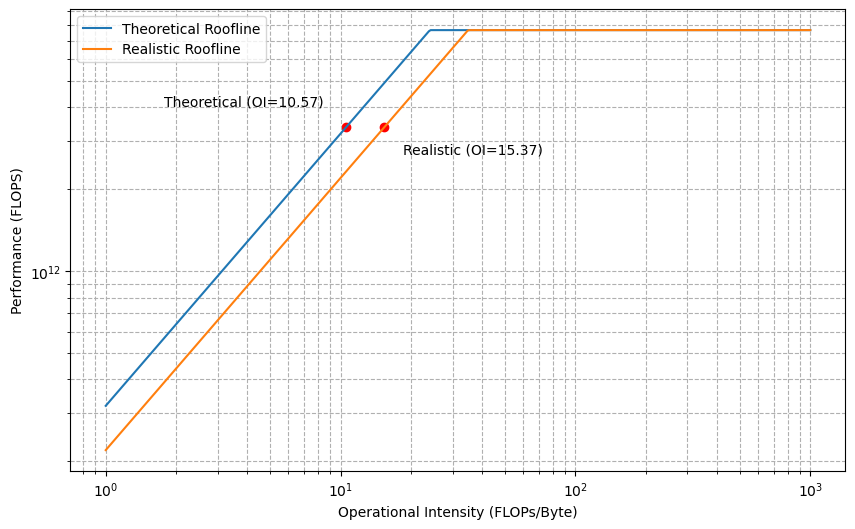

In [14]:
import numpy as np 

# Constants and Roofline Parameters Setup
sm_count = 40              # Number of Streaming Multiprocessors
cores_per_sm = 64          # Number of SP FP cores per SM
clock_speed_ghz = 1.5      # Clock speed in GHz
flops_per_cycle_per_core = 2  # Operations per cycle per core (FPMAD)

# Compute Peak Performance
peak_performance_tflops = sm_count * cores_per_sm * clock_speed_ghz * flops_per_cycle_per_core / 1000  # TFLOPS
peak_performance = peak_performance_tflops * 1e12  # Convert TFLOPS to FLOPS

# Memory Bandwidths
memory_bandwidth_gibs = 320  # Theoretical GiB/s
memory_bandwidth_real_gibs = 220  # Realistic GiB/s
memory_bandwidth = memory_bandwidth_gibs * 8 * 1e9 / 8  # Convert GiB/s to B/s
memory_bandwidth_real = memory_bandwidth_real_gibs * 8 * 1e9 / 8  # Convert GiB/s to B/s

# Achieved Performance
achieved_performance_flops = 3382.27 * 1e9  # GFLOPS to FLOPS
operational_intensity_achieved = achieved_performance_flops / memory_bandwidth  # FLOPs/Byte theoretical
operational_intensity_achieved_real = achieved_performance_flops / memory_bandwidth_real  # FLOPs/Byte realistic

# Calculate achievable performance for both scenarios
operational_intensity = np.logspace(0, 3, 400)  # FLOPs/byte range
achievable_performance = np.minimum(peak_performance, operational_intensity * memory_bandwidth)
achievable_performance_real = np.minimum(peak_performance, operational_intensity * memory_bandwidth_real)

# Plotting the Roofline Model for Theoretical and Realistic Scenarios
plt.figure(figsize=(10, 6))
plt.loglog(operational_intensity, achievable_performance, label='Theoretical Roofline')
plt.loglog(operational_intensity, achievable_performance_real, label='Realistic Roofline')
plt.scatter([operational_intensity_achieved, operational_intensity_achieved_real], 
            [achieved_performance_flops, achieved_performance_flops], color='red')
plt.text(operational_intensity_achieved*0.8, achieved_performance_flops * 1.2, 
         f'Theoretical (OI={operational_intensity_achieved:.2f})', horizontalalignment='right')
plt.text(operational_intensity_achieved_real*1.2, achieved_performance_flops * 0.8, 
         f'Realistic (OI={operational_intensity_achieved_real:.2f})', horizontalalignment='left')

# Annotations and Plot Settings
# plt.title('Theoretical and Realistic Roofline Model for NVIDIA T4 GPU')
plt.xlabel('Operational Intensity (FLOPs/Byte)')
plt.ylabel('Performance (FLOPS)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig("img/roofline")
# Show the plot
plt.show()


In [15]:
peak_performance / memory_bandwidth

24.0